In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from qso_sample import QSOSample
import dipole
import multipoles

### load shot noise estimates

#### CatWISE

In [3]:
# on the full sky, only fitting up to the dipole
res_full = np.load('/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_full = res_full['Cells_fullsky'][0]
res_full['comment']

'CatWISE AGNs, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq'

In [4]:
# on the CUT sky, only fitting up to the dipole, varying Wmask
res_cut = np.load('/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_cutsky_ellmax1_100trials.npy', allow_pickle=True).item()
Wmasks, noise_cut = list(zip(*res_cut['Cells_cutsky']))
idx_sorted = np.argsort(Wmasks)
Wmasks = np.array(Wmasks)[idx_sorted]
noise_cut = np.array(noise_cut)[idx_sorted]

In [11]:
# interpolate on a finer grid
Wmasks_fine = np.logspace(np.log10(min(Wmasks)), np.log10(max(Wmasks)), 101)
noise_cut_fine = np.interp(Wmasks_fine, Wmasks, noise_cut.flatten())

Text(0.5, 1.0, 'CatWISE shot noise estimates')

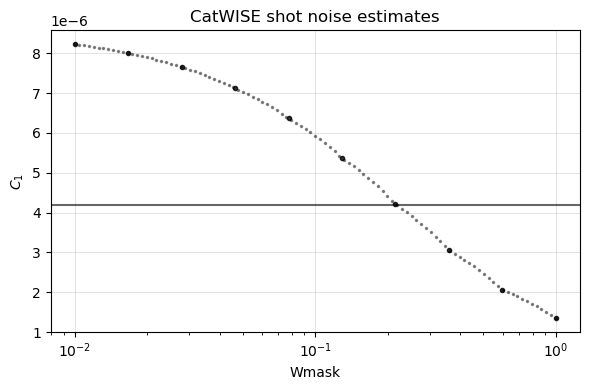

In [13]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(Wmasks, noise_cut, 'k.', lw=0.5, alpha=0.8)
ax.plot(Wmasks_fine, noise_cut_fine, 'k.', ms=3, lw=0.5, alpha=0.4)
ax.axhline(noise_full, c='k', alpha=0.6, lw=1.5)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogx()
ax.set_xlabel('Wmask')
ax.set_ylabel(r'$C_1$')
ax.set_title('CatWISE shot noise estimates')

In [14]:
# find closest Wmask in the interpolated list to the C_1 on the full sky
idx_closest = np.abs(noise_cut_fine - noise_full).argmin()
Wmasks_fine[idx_closest]

0.2187761623949553

#### Quaia

In [15]:
# on the full sky, only fitting up to the dipole
res_full = np.load('/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_full = res_full['Cells_fullsky'][0]
res_full['comment']

'Quaia G<20.0, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq'

In [16]:
# on the CUT sky, only fitting up to the dipole, varying Wmask
res_cut = np.load('/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_cutsky_ellmax1_100trials.npy', allow_pickle=True).item()
Wmasks, noise_cut = list(zip(*res_cut['Cells_cutsky']))
idx_sorted = np.argsort(Wmasks)
Wmasks = np.array(Wmasks)[idx_sorted]
noise_cut = np.array(noise_cut)[idx_sorted]

In [17]:
# interpolate on a finer grid
Wmasks_fine = np.logspace(np.log10(min(Wmasks)), np.log10(max(Wmasks)), 101)
noise_cut_fine = np.interp(Wmasks_fine, Wmasks, noise_cut.flatten())

Text(0.5, 1.0, 'Quaia G<20.0 shot noise estimates')

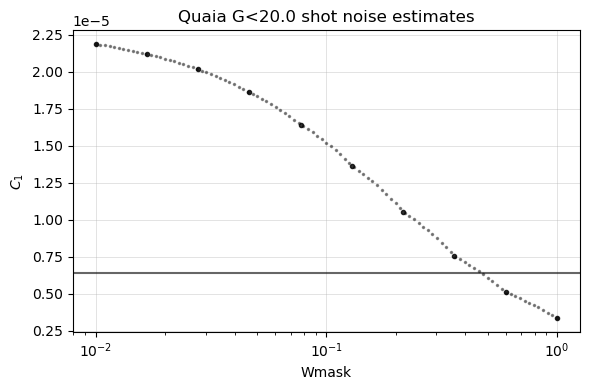

In [18]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(Wmasks, noise_cut, 'k.', lw=0.5, alpha=0.8)
ax.plot(Wmasks_fine, noise_cut_fine, 'k.', ms=3, lw=0.5, alpha=0.4)
ax.axhline(noise_full, c='k', alpha=0.6, lw=1.5)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogx()
ax.set_xlabel('Wmask')
ax.set_ylabel(r'$C_1$')
ax.set_title('Quaia G<20.0 shot noise estimates')

In [19]:
# find closest Wmask in the interpolated list to the C_1 on the full sky
idx_closest = np.abs(noise_cut_fine - noise_full).argmin()
Wmasks_fine[idx_closest]

0.47863009232263826